<a href="https://colab.research.google.com/github/A00785001/TC5035/blob/main/001_EDA_Image_Branch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis - Image Branch
Extract and analyze data from ROS bags with image EDA

## <font color='#2E86AB'>▼ 1. Initialization and Setup</font>

In [1]:
# Install required packages
!pip install --quiet rosbags opencv-python pillow numpy matplotlib tqdm seaborn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 34.8 MB/s eta 0:00:00


In [2]:
# Import libraries
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
from datetime import datetime
from tqdm import tqdm
from collections import defaultdict
import io

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [3]:
from rosbags.rosbag1 import Reader
from rosbags.typesys import Stores, get_typestore
import os
from pathlib import Path
print("Libraries loaded successfully!")

Libraries loaded successfully!


In [4]:
# Initialize typestore for ROS1 message deserialization
typestore = get_typestore(Stores.ROS1_NOETIC)
print("Typestore initialized for ROS1")

Typestore initialized for ROS1


## <font color='#2E86AB'>▼ 2. Storage Mounting</font>

In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## <font color='#2E86AB'>▼ 3. ROS Bag Load</font>

In [6]:
# Specify the path to the sessions folder
data_path = "/content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/"

In [7]:
# Specify the session
session = '20251016_133216'
print(f"Using session: {session}")

Using session: 20251016_133216


In [8]:
working_folder = data_path + 'session_' + session
bag_name = 'session_data.bag'

# Change to the specified subfolder
os.chdir(working_folder)
print(f"Changed directory to: {os.getcwd()}")

Changed directory to: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251016_133216


In [9]:
bag_file = working_folder + '/' + bag_name
print(f"Bag file name: {bag_name}")

# Set bag_path for the rest of the notebook
bag_path = bag_file

Bag file name: session_data.bag


## <font color='#2E86AB'>▼ 4. ROS Bag Basic EDA</font>

### 1. Basic Bag Information

In [10]:
# Open the bag and get basic information
print("=" * 60)
print("BASIC BAG INFORMATION")
print("=" * 60)

with Reader(bag_path) as reader:
    # Get basic statistics
    duration = reader.duration * 1e-9  # Convert to seconds
    duration_sec = duration
    total_messages = reader.message_count

    # Get file size
    file_size_bytes = os.path.getsize(bag_path)
    file_size_mb = file_size_bytes / (1024 * 1024)

    # Calculate average message rate
    avg_message_rate = total_messages / duration if duration > 0 else 0

    print(f"\n📁 File: {bag_name}")
    print(f"💾 Size: {file_size_mb:.2f} MB")
    print(f"⏱️  Duration: {duration:.2f} seconds ({duration/60:.2f} minutes)")
    print(f"📬 Total Messages: {total_messages:,}")
    print(f"📊 Average Rate: {avg_message_rate:.2f} msg/sec")

BASIC BAG INFORMATION

📁 File: session_data.bag
💾 Size: 34.35 MB
⏱️  Duration: 463.17 seconds (7.72 minutes)
📬 Total Messages: 98,205
📊 Average Rate: 212.03 msg/sec


### 2. Topic Analysis

In [11]:
# Analyze topics and connections
print("=" * 60)
print("TOPIC ANALYSIS (ROS1 BAG)")
print("=" * 60)

import struct

def parse_tf_binary(rawdata):
    """Parse TF message from raw bytes"""
    transforms = set()
    for start_offset in [0, 4, 8, 12, 16]:
        try:
            offset = start_offset
            array_len = struct.unpack('<I', rawdata[offset:offset+4])[0]
            if array_len > 100 or array_len == 0:
                continue
            offset += 4

            for _ in range(min(array_len, 5)):
                offset += 12  # Skip seq + stamp
                str_len = struct.unpack('<I', rawdata[offset:offset+4])[0]
                if str_len > 100 or str_len == 0:
                    break
                offset += 4
                parent = rawdata[offset:offset+str_len].decode('utf-8', errors='ignore').strip('\\x00').strip('/')
                offset += str_len

                str_len = struct.unpack('<I', rawdata[offset:offset+4])[0]
                if str_len > 100 or str_len == 0:
                    break
                offset += 4
                child = rawdata[offset:offset+str_len].decode('utf-8', errors='ignore').strip('\\x00').strip('/')
                offset += str_len + 56  # Skip transform data

                if parent and child and len(parent) < 50 and len(child) < 50:
                    transforms.add(f"{parent}→{child}")
            if transforms:
                return transforms
        except:
            continue
    return transforms

# Get basic topic information with connection indices
with Reader(bag_path) as reader:
    topics_data = []
    connection_map = {}  # Store connection index mapping

    for conn_idx, connection in enumerate(reader.connections):
        topics_data.append({
            'Topic': connection.topic,
            'Message Type': connection.msgtype,
            'Count': connection.msgcount,
            'Connection_Index': conn_idx,
            'Description': ""
        })
        # Map for later use
        connection_map[conn_idx] = {'topic': connection.topic, 'msgtype': connection.msgtype, 'msgcount': connection.msgcount}

    df_topics = pd.DataFrame(topics_data)

# Analyze TF connections
print("\\n🔍 Analyzing TF connections...")
with Reader(bag_path) as reader:
    tf_connection_data = {}

    for conn_idx, conn in enumerate(reader.connections):
        if conn.topic in ['/tf', '/tf_static']:
            tf_connection_data[conn_idx] = {'transforms': set(), 'samples': 0}

    for connection, timestamp, rawdata in reader.messages():
        if connection.topic in ['/tf', '/tf_static']:
            conn_idx = None
            for idx, conn in enumerate(reader.connections):
                if (conn.topic == connection.topic and
                    conn.msgtype == connection.msgtype and
                    conn.msgcount == connection.msgcount):
                    conn_idx = idx
                    break

            if conn_idx is not None and conn_idx in tf_connection_data:
                if tf_connection_data[conn_idx]['samples'] < 10:
                    try:
                        msg = typestore.deserialize_ros1(rawdata, connection.msgtype)
                        for tf in msg.transforms:
                            parent = tf.header.frame_id.strip('/')
                            child = tf.child_frame_id.strip('/')
                            tf_connection_data[conn_idx]['transforms'].add(f"{parent}→{child}")
                    except:
                        binary_transforms = parse_tf_binary(rawdata)
                        if binary_transforms:
                            tf_connection_data[conn_idx]['transforms'].update(binary_transforms)
                    tf_connection_data[conn_idx]['samples'] += 1

# Classify TF connections
for idx, row in df_topics.iterrows():
    if row['Topic'] in ['/tf', '/tf_static']:
        conn_idx = row['Connection_Index']

        if conn_idx in tf_connection_data:
            transforms = tf_connection_data[conn_idx]['transforms']

            if transforms:
                transforms_str = ', '.join(sorted(transforms)[:5])
                if len(transforms) > 5:
                    transforms_str += f" (+{len(transforms)-5} more)"

                transforms_lower = ' '.join(transforms).lower()

                if 'map' in transforms_lower and 'odom' in transforms_lower:
                    classification = "SLAM"
                elif 'odom' in transforms_lower and 'base' in transforms_lower:
                    classification = "Odometry"
                elif 'imu' in transforms_lower or 'laser' in transforms_lower or 'camera' in transforms_lower:
                    classification = "Static"
                else:
                    classification = "Other"

                df_topics.at[idx, 'Description'] = f"{classification}: {transforms_str}"
            else:
                freq = row['Count'] / duration_sec
                if freq > 40:
                    classification = "SLAM"
                elif freq > 30:
                    classification = "Odometry"
                elif freq > 15:
                    classification = "Static"
                else:
                    classification = "Other"
                df_topics.at[idx, 'Description'] = f"{classification} (by frequency)"

# Display
df_topics_display = df_topics.drop('Connection_Index', axis=1)
df_topics_display = df_topics_display.sort_values('Count', ascending=False)
df_topics_display['Frequency (Hz)'] = df_topics_display['Count'] / duration_sec

print(f"\\n📊 Total Connections: {len(df_topics_display)}")
print(f"📊 Unique Topics: {df_topics_display['Topic'].nunique()}")
print(f"\\n{df_topics_display.to_string(index=False)}")

df_topics_display.to_csv('topic_statistics.csv', index=False)
print(f"\\n✅ Topic statistics saved to: topic_statistics.csv")

unique_topics = df_topics_display['Topic'].tolist()


TOPIC ANALYSIS (ROS1 BAG)
\n🔍 Analyzing TF connections...
\n📊 Total Connections: 13
📊 Unique Topics: 10
\n                          Topic                         Message Type  Count                          Description  Frequency (Hz)
                            /tf               tf2_msgs/msg/TFMessage  20459   Static: base_footprint→laser_frame       44.172132
                            /tf               tf2_msgs/msg/TFMessage  17614 Static: base_footprint→base_imu_link       38.029617
                            /tf               tf2_msgs/msg/TFMessage  16294  SLAM: map→odom, odom→base_footprint       35.179663
                       /cmd_vel              geometry_msgs/msg/Twist  11418                                            24.652104
                           /imu                  sensor_msgs/msg/Imu   9553                                            20.625464
                            /tf               tf2_msgs/msg/TFMessage   8928        Odometry: odom→base_footprint       1

### 3. Message Frequency Distribution

In [12]:
# Analyze message frequency distribution
print("=" * 60)
print("MESSAGE FREQUENCY DISTRIBUTION")
print("=" * 60)

with Reader(bag_path) as reader:
    connection_timestamps = defaultdict(list)  # Track by connection index
    topic_timestamps = defaultdict(list)  # Also track by topic for backward compatibility

    print("\\nCollecting timestamps...")
    for connection, timestamp, rawdata in tqdm(reader.messages(), total=reader.message_count):
        topic = connection.topic
        timestamp_sec = timestamp * 1e-9

        # Add to topic_timestamps
        topic_timestamps[topic].append(timestamp_sec)

        # Find connection index for detailed tracking
        conn_idx = None
        for idx, conn in enumerate(reader.connections):
            if (conn.topic == connection.topic and
                conn.msgtype == connection.msgtype and
                conn.msgcount == connection.msgcount):
                conn_idx = idx
                break

        if conn_idx is not None:
            connection_timestamps[conn_idx].append(timestamp_sec)

    print("\\n📈 Inter-Message Interval Statistics (by connection):")
    print(f"{'Topic':<40} {'Description':<30} {'Mean (ms)':<12} {'Std (ms)':<12}")
    print("-" * 94)

    for conn_idx in sorted(connection_timestamps.keys()):
        timestamps = connection_timestamps[conn_idx]
        if len(timestamps) > 1:
            intervals = np.diff(timestamps) * 1000

            # Get topic info from df_topics
            topic_row = df_topics[df_topics['Connection_Index'] == conn_idx].iloc[0]
            topic_name = topic_row['Topic']
            description = topic_row['Description'][:28] if topic_row['Description'] else ''

            print(f"{topic_name:<40} {description:<30} {np.mean(intervals):<12.2f} {np.std(intervals):<12.2f}")


MESSAGE FREQUENCY DISTRIBUTION
\nCollecting timestamps...


100%|██████████| 98205/98205 [00:00<00:00, 141138.91it/s]


\n📈 Inter-Message Interval Statistics (by connection):
Topic                                    Description                    Mean (ms)    Std (ms)    
----------------------------------------------------------------------------------------------
/csi_cam_0/camera_info                                                  59.50        500.15      
/constraint_list                                                        2766.79      10945.50    
/csi_cam_0/image_raw/compressed                                         4480.40      3405.35     
/imu                                                                    46.95        447.40      
/odom                                                                   111.79       1323.80     
/scan                                                                   1427.87      3374.64     
/tf                                      SLAM: map→odom, odom→base_fo   27.52        258.56      
/tf                                      Static: base_footprint→la

### 4. Message Size Distribution Analysis

In [13]:
# Analyze message sizes per connection
print("=" * 60)
print("MESSAGE SIZE ANALYSIS")
print("=" * 60)

with Reader(bag_path) as reader:
    connection_sizes = defaultdict(list)

    print("\\nCollecting message sizes...")
    for connection, timestamp, rawdata in tqdm(reader.messages(), total=reader.message_count):
        # Find connection index
        conn_idx = None
        for idx, conn in enumerate(reader.connections):
            if (conn.topic == connection.topic and
                conn.msgtype == connection.msgtype and
                conn.msgcount == connection.msgcount):
                conn_idx = idx
                break

        if conn_idx is not None:
            connection_sizes[conn_idx].append(len(rawdata))

    # Calculate statistics
    size_stats = []
    for conn_idx, sizes in connection_sizes.items():
        sizes_array = np.array(sizes)
        topic_row = df_topics[df_topics['Connection_Index'] == conn_idx].iloc[0]

        size_stats.append({
            'Topic': topic_row['Topic'],
            'Description': topic_row['Description'][:40] if topic_row['Description'] else '',
            'Avg Size (bytes)': np.mean(sizes_array),
            'Total Size (MB)': np.sum(sizes_array) / (1024 * 1024)
        })

    df_sizes = pd.DataFrame(size_stats)
    df_sizes = df_sizes.sort_values('Total Size (MB)', ascending=False)

    print("\\n📏 Message Size Statistics:")
    print(df_sizes.to_string(index=False))

    df_sizes.to_csv('message_size_statistics.csv', index=False)


MESSAGE SIZE ANALYSIS
\nCollecting message sizes...


100%|██████████| 98205/98205 [00:00<00:00, 134970.32it/s]


\n📏 Message Size Statistics:
                          Topic                          Description  Avg Size (bytes)  Total Size (MB)
/csi_cam_0/image_raw/compressed                                           35867.980000         3.420637
                           /imu                                             325.000000         2.960896
                            /tf  SLAM: map→odom, odom→base_footprint        181.000000         2.812590
                          /scan                                            9239.000000         2.775464
                          /odom                                             719.000000         2.751681
          /trajectory_node_list                                            6978.941463         2.728811
         /csi_cam_0/camera_info                                             361.000000         2.680192
                            /tf   Static: base_footprint→laser_frame        107.000000         2.087701
               /constraint_list    

### 5. ROS Bag Basic EDA Summary Report

In [14]:
# Generate ROS Bag Basic EDA summary report
print("=" * 60)
print("ROS BAG BASIC EDA - SUMMARY REPORT")
print("=" * 60)

rosbag_summary = f"""
📊 ROS BAG BASIC EDA SUMMARY
{'='*60}

FILE INFORMATION:
  • File: {bag_name}
  • Size: {file_size_mb:.2f} MB
  • Duration: {duration_sec:.2f} seconds ({duration_sec/60:.2f} minutes)

MESSAGE STATISTICS:
  • Total Messages: {total_messages:,}
  • Unique Topics: {len(unique_topics)}
  • Message Types: {df_topics['Message Type'].nunique()}
  • Average Rate: {avg_message_rate:.2f} msg/sec

DATA QUALITY:
  • Average Data Rate: {file_size_mb / (duration_sec/60):.2f} MB/min

TOP 3 TOPICS BY SIZE:
"""

for idx, row in df_sizes.head(3).iterrows():
    rosbag_summary += f"  {idx+1}. {row['Topic']}: {row['Total Size (MB)']:.2f} MB\n"

print(rosbag_summary)

# Save report
with open('rosbag_basic_eda_summary.txt', 'w') as f:
    f.write(rosbag_summary)

print("\n✅ ROS Bag Basic EDA summary saved to: rosbag_basic_eda_summary.txt")

ROS BAG BASIC EDA - SUMMARY REPORT

📊 ROS BAG BASIC EDA SUMMARY

FILE INFORMATION:
  • File: session_data.bag
  • Size: 34.35 MB
  • Duration: 463.17 seconds (7.72 minutes)

MESSAGE STATISTICS:
  • Total Messages: 98,205
  • Unique Topics: 13
  • Message Types: 9
  • Average Rate: 212.03 msg/sec

DATA QUALITY:
  • Average Data Rate: 4.45 MB/min

TOP 3 TOPICS BY SIZE:
  3. /csi_cam_0/image_raw/compressed: 3.42 MB
  4. /imu: 2.96 MB
  7. /tf: 2.81 MB


✅ ROS Bag Basic EDA summary saved to: rosbag_basic_eda_summary.txt


### Hardware Documentation: JetBot Camera System

---

## 📷 Hardware Specifications

**Camera Sensor: Sony IMX219**

- **Native Resolution:** 8MP (3280 × 2464 pixels)
- **Typical Operating Modes:**
  - 640 × 480 pixels (VGA, 4:3)
  - 1280 × 720 pixels (HD, 16:9)
- **Field of View:** 160° (wide angle)
- **Interface:** CSI (Camera Serial Interface)
- **Frame Rate:** Up to 30 FPS (depends on resolution and configuration)

---

## 📡 ROS Topics Published

The JetBot camera system typically publishes three topics:

### 1. `/csi_cam_0/image_raw` (Uncompressed Images)

**Message Type:** `sensor_msgs/Image`

**Content:** Raw uncompressed pixel data

**Message Fields:**
- `header` - Timestamp and frame ID
- `height` - Image height (480 or 720)
- `width` - Image width (640 or 1280)
- `encoding` - Pixel format (`"bgr8"` or `"rgb8"`)
- `step` - Row stride in bytes
- `data` - Raw pixel array

**Data Size:**
- 640×480: ~921 KB per frame
- 1280×720: ~2.76 MB per frame

**Note:** Often disabled by default to save bandwidth

---

### 2. `/csi_cam_0/image_raw/compressed` (Compressed Images)

**Message Type:** `sensor_msgs/CompressedImage`

**Content:** JPEG-compressed images

**Message Fields:**
- `header` - Timestamp and frame ID
- `format` - Compression type (`"jpeg"`)
- `data` - Compressed image bytes

**Data Size:**
- Simple scenes: 20-40 KB per frame
- Complex scenes: 40-80 KB per frame
- **Compression ratio:** 10-40× smaller than raw

**Default Topic:** This is the primary topic used in most JetBot applications

---

### 3. `/csi_cam_0/camera_info` (Camera Calibration)

**Message Type:** `sensor_msgs/CameraInfo`

**Content:** Camera calibration parameters and metadata

**Message Fields:**

**Image Dimensions:**
- `width` - Image width in pixels
- `height` - Image height in pixels

**Intrinsic Calibration:**
- `K` - 3×3 camera matrix
  - `K[0,0]` = fx (focal length X)
  - `K[1,1]` = fy (focal length Y)
  - `K[0,2]` = cx (principal point X, ~width/2)
  - `K[1,2]` = cy (principal point Y, ~height/2)

**Distortion:**
- `distortion_model` - Usually `"plumb_bob"`
- `D` - Distortion coefficients [k1, k2, p1, p2, k3]
  - k1, k2, k3: Radial distortion
  - p1, p2: Tangential distortion

**Projection:**
- `R` - 3×3 rectification matrix (identity for monocular)
- `P` - 3×4 projection matrix for 3D→2D mapping

**Region of Interest:**
- `roi` - Subset of image for processing (all zeros = full image)

**Binning:**
- `binning_x`, `binning_y` - Pixel binning (usually 0)

**Expected Values (640×480 mode):**
```
width: 640, height: 480
fx, fy: 600-900 pixels
cx: ~320, cy: ~240
distortion_model: "plumb_bob"
```

**Calibration Status:**
- **Calibrated:** K matrix has non-zero values
- **Uncalibrated:** K, D, R, P may be zeros


### Camera Info Topic Inspection

In [15]:
# Inspect camera_info topic - Optimized with Binary Parsing Fallback
print("=" * 60)
print("CAMERA INFO TOPIC INSPECTION")
print("=" * 60)

camera_info_topic = '/csi_cam_0/camera_info'

def display_camera_info(cam_data, parsing_method="Standard"):
    """Display camera info in a consistent format"""
    print(f"\n📷 CAMERA CALIBRATION INFO ({parsing_method} Parsing):")
    print("=" * 60)
    print(f"\nImage Dimensions:")
    print(f"  • Width: {cam_data['width']} pixels")
    print(f"  • Height: {cam_data['height']} pixels")
    print(f"  • Aspect Ratio: {cam_data['width']/cam_data['height']:.2f}")

    print(f"\nDistortion Model: {cam_data['distortion_model']}")

    print(f"\nCamera Matrix (K):")
    print(cam_data['K'])
    print(f"  • Focal Length X (fx): {cam_data['K'][0,0]:.2f}")
    print(f"  • Focal Length Y (fy): {cam_data['K'][1,1]:.2f}")
    print(f"  • Principal Point X (cx): {cam_data['K'][0,2]:.2f}")
    print(f"  • Principal Point Y (cy): {cam_data['K'][1,2]:.2f}")

    print(f"\nDistortion Coefficients (D):")
    if len(cam_data['D']) > 0:
        print(f"  {list(cam_data['D'])}")
    else:
        print(f"  None")

    print(f"\nRectification Matrix (R):")
    print(cam_data['R'])

    print(f"\nProjection Matrix (P):")
    print(cam_data['P'])

    print(f"\nRegion of Interest (ROI):")
    print(f"  • X offset: {cam_data['roi']['x']}")
    print(f"  • Y offset: {cam_data['roi']['y']}")
    print(f"  • Width: {cam_data['roi']['width']}")
    print(f"  • Height: {cam_data['roi']['height']}")
    print(f"  • Do rectify: {cam_data['roi']['do_rectify']}")

def parse_camerainfo_binary(rawdata):
    """Parse CameraInfo from raw bytes when standard deserialization fails"""
    import struct

    offset = 4  # Skip CDR header

    # Parse header fields (seq, timestamp, frame_id) - skip for now
    offset += 12  # seq(4) + secs(4) + nsecs(4)
    str_len = struct.unpack('<I', rawdata[offset:offset+4])[0]
    offset += 4 + str_len  # frame_id

    # Image dimensions
    height = struct.unpack('<I', rawdata[offset:offset+4])[0]
    width = struct.unpack('<I', rawdata[offset+4:offset+8])[0]
    offset += 8

    # Distortion model
    str_len = struct.unpack('<I', rawdata[offset:offset+4])[0]
    distortion_model = rawdata[offset+4:offset+4+str_len].decode('utf-8', errors='ignore').rstrip('\x00')
    offset += 4 + str_len

    # D array
    d_count = struct.unpack('<I', rawdata[offset:offset+4])[0]
    offset += 4
    d_values = struct.unpack(f'<{d_count}d', rawdata[offset:offset+d_count*8])
    offset += d_count * 8

    # K, R, P matrices
    k_matrix = np.array(struct.unpack('<9d', rawdata[offset:offset+72])).reshape(3, 3)
    offset += 72
    r_matrix = np.array(struct.unpack('<9d', rawdata[offset:offset+72])).reshape(3, 3)
    offset += 72
    p_matrix = np.array(struct.unpack('<12d', rawdata[offset:offset+96])).reshape(3, 4)
    offset += 96

    # Binning and ROI
    binning_x, binning_y = struct.unpack('<II', rawdata[offset:offset+8])
    offset += 8
    roi_x, roi_y, roi_h, roi_w = struct.unpack('<IIII', rawdata[offset:offset+16])
    offset += 16
    roi_do_rectify = struct.unpack('<?', rawdata[offset:offset+1])[0]

    return {
        'width': width, 'height': height,
        'distortion_model': distortion_model,
        'D': d_values, 'K': k_matrix, 'R': r_matrix, 'P': p_matrix,
        'roi': {'x': roi_x, 'y': roi_y, 'width': roi_w, 'height': roi_h, 'do_rectify': roi_do_rectify}
    }

# Main parsing logic
with Reader(bag_path) as reader:
    topics = [conn.topic for conn in reader.connections]

    if camera_info_topic in topics:
        print(f"\n✓ Found topic: {camera_info_topic}\n")

        for connection, timestamp, rawdata in reader.messages():
            if connection.topic == camera_info_topic:
                try:
                    # Try standard deserialization first
                    msg = typestore.deserialize_ros1(rawdata, connection.msgtype)

                    cam_data = {
                        'width': msg.width, 'height': msg.height,
                        'distortion_model': msg.distortion_model,
                        'D': msg.D,
                        'K': np.array(msg.K).reshape(3, 3),
                        'R': np.array(msg.R).reshape(3, 3),
                        'P': np.array(msg.P).reshape(3, 4),
                        'roi': {'x': msg.roi.x_offset, 'y': msg.roi.y_offset,
                               'width': msg.roi.width, 'height': msg.roi.height,
                               'do_rectify': msg.roi.do_rectify}
                    }
                    display_camera_info(cam_data, "Standard")
                    break

                except (UnicodeDecodeError, Exception) as e:
                    # Fallback to binary parsing
                    try:
                        print("⚠️  Standard deserialization failed, using binary parsing...\n")
                        cam_data = parse_camerainfo_binary(rawdata)
                        display_camera_info(cam_data, "Binary")
                        print(f"\n✅ Successfully parsed camera info!")
                        break
                    except Exception as e2:
                        print(f"❌ Both parsing methods failed: {type(e2).__name__}")
                        print(f"\nBasic topic info:")
                        print(f"  • Topic: {camera_info_topic}")
                        print(f"  • Message type: {connection.msgtype}")
                        print(f"  • Message count: {connection.msgcount}")
                        print(f"\n💡 Camera dimensions will be extracted from images in the next section.")
                        break
    else:
        print(f"\n⚠️  Topic {camera_info_topic} not found in bag file")
        print(f"\nAvailable topics:")
        for topic in sorted(topics):
            print(f"  • {topic}")


CAMERA INFO TOPIC INSPECTION

✓ Found topic: /csi_cam_0/camera_info


📷 CAMERA CALIBRATION INFO (Standard Parsing):

Image Dimensions:
  • Width: 640 pixels
  • Height: 480 pixels
  • Aspect Ratio: 1.33

Distortion Model: plumb_bob

Camera Matrix (K):
[[400.23335572   0.         331.45496717]
 [  0.         533.28378008 263.35673215]
 [  0.           0.           1.        ]]
  • Focal Length X (fx): 400.23
  • Focal Length Y (fy): 533.28
  • Principal Point X (cx): 331.45
  • Principal Point Y (cy): 263.36

Distortion Coefficients (D):
  [np.float64(-0.3099359644894822), np.float64(0.08151662693197913), np.float64(0.0006660916041993709), np.float64(0.001461474111496217), np.float64(0.0)]

Rectification Matrix (R):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Projection Matrix (P):
[[301.49786377   0.         340.74247121   0.        ]
 [  0.         494.35562134 266.73894881   0.        ]
 [  0.           0.           1.           0.        ]]

Region of Interest (ROI):
  • X offset: 0
  • Y

## <font color='#2E86AB'>▼ 5. Camera Topic Basic EDA</font>

### 1. Camera Topic Timing Analysis

CAMERA TOPIC TIMING ANALYSIS: /csi_cam_0/image_raw/compressed

📸 Frame Statistics:
   Total frames: 100
   Duration: 443.56 seconds
   Average FPS: 115.59
   FPS std dev: 565.84
   Min FPS: 0.03
   Max FPS: 4359.98

⚠️  Gap Analysis:
   Gap threshold: 11.2911 seconds
   Number of large gaps: 2
   Largest gap: 30.0548 seconds at index 52


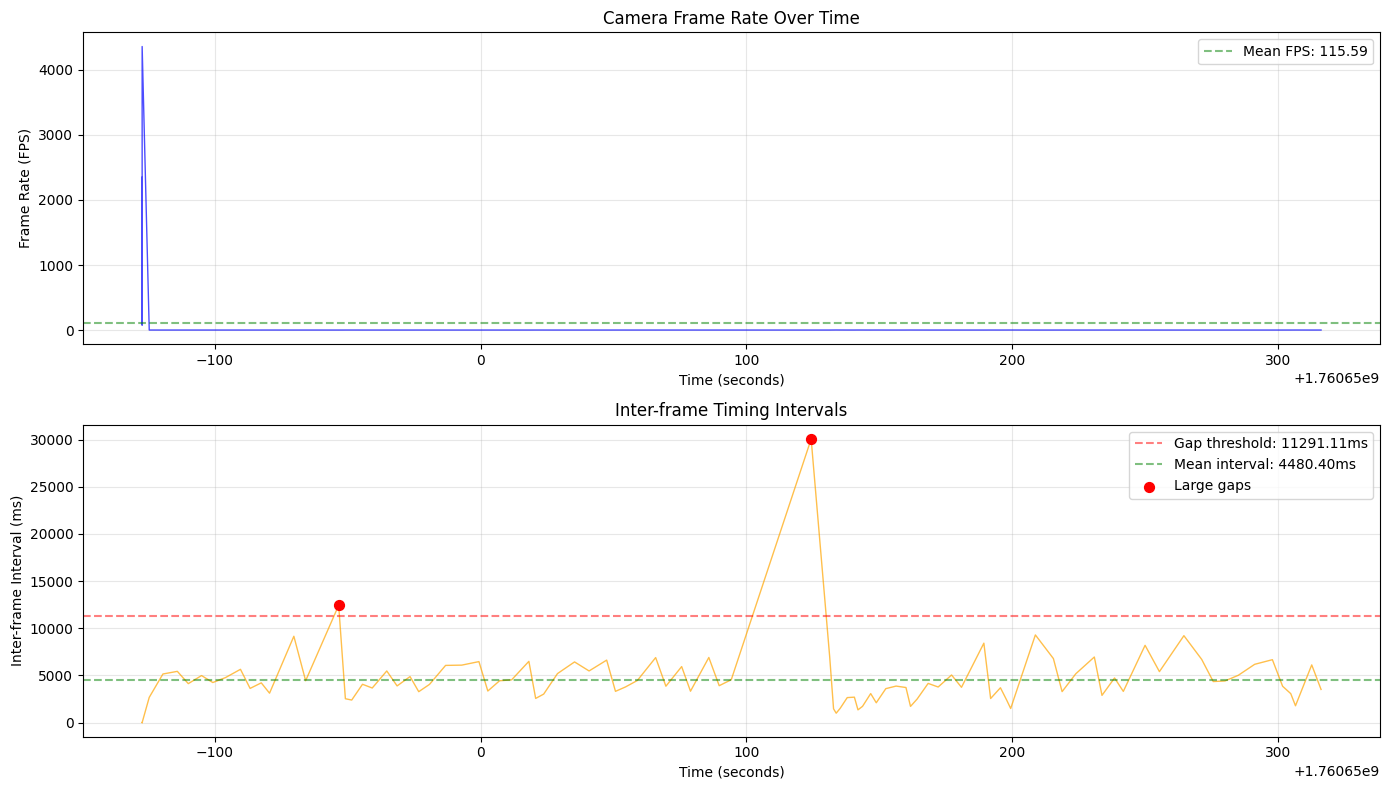


✅ Camera timing plot saved to: camera_timing_analysis.png


In [16]:
# Detailed analysis of camera topic timing
camera_topic = '/csi_cam_0/image_raw/compressed'

print("=" * 60)
print(f"CAMERA TOPIC TIMING ANALYSIS: {camera_topic}")
print("=" * 60)

if camera_topic in topic_timestamps:
    timestamps = np.array(topic_timestamps[camera_topic])
    time_diffs = np.diff(timestamps)
    framerates = 1.0 / time_diffs

    print(f"\n📸 Frame Statistics:")
    print(f"   Total frames: {len(timestamps)}")
    print(f"   Duration: {timestamps[-1] - timestamps[0]:.2f} seconds")
    print(f"   Average FPS: {np.mean(framerates):.2f}")
    print(f"   FPS std dev: {np.std(framerates):.2f}")
    print(f"   Min FPS: {np.min(framerates):.2f}")
    print(f"   Max FPS: {np.max(framerates):.2f}")

    # Detect large gaps
    gap_threshold = np.mean(time_diffs) + 2 * np.std(time_diffs)
    large_gaps = np.where(time_diffs > gap_threshold)[0]

    print(f"\n⚠️  Gap Analysis:")
    print(f"   Gap threshold: {gap_threshold:.4f} seconds")
    print(f"   Number of large gaps: {len(large_gaps)}")
    if len(large_gaps) > 0:
        print(f"   Largest gap: {np.max(time_diffs):.4f} seconds at index {np.argmax(time_diffs)}")

    # Plot timing analysis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

    # Plot 1: Frame rate over time
    ax1.plot(timestamps[1:], framerates, linewidth=1, color='blue', alpha=0.7)
    ax1.axhline(y=np.mean(framerates), color='green', linestyle='--', alpha=0.5, label=f'Mean FPS: {np.mean(framerates):.2f}')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Frame Rate (FPS)')
    ax1.set_title('Camera Frame Rate Over Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Inter-frame intervals with gap detection
    ax2.plot(timestamps[1:], time_diffs * 1000, linewidth=1, color='orange', alpha=0.7)
    ax2.axhline(y=gap_threshold * 1000, color='red', linestyle='--', alpha=0.5, label=f'Gap threshold: {gap_threshold*1000:.2f}ms')
    ax2.axhline(y=np.mean(time_diffs) * 1000, color='green', linestyle='--', alpha=0.5, label=f'Mean interval: {np.mean(time_diffs)*1000:.2f}ms')

    # Mark large gaps
    if len(large_gaps) > 0:
        ax2.scatter(timestamps[large_gaps+1], time_diffs[large_gaps] * 1000, color='red', s=50, zorder=5, label='Large gaps')

    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Inter-frame Interval (ms)')
    ax2.set_title('Inter-frame Timing Intervals')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('camera_timing_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✅ Camera timing plot saved to: camera_timing_analysis.png")
else:
    print(f"\n⚠️  Camera topic {camera_topic} not found")

### 2. Camera Topic Basic EDA Summary Report

In [17]:
# Generate Camera Topic Basic EDA summary report
print("=" * 60)
print("CAMERA TOPIC BASIC EDA - SUMMARY REPORT")
print("=" * 60)

if camera_topic in topic_timestamps:
    camera_summary = f"""
📸 CAMERA TOPIC BASIC EDA SUMMARY
{'='*60}

TOPIC INFORMATION:
  • Topic: {camera_topic}
  • Total Messages: {len(timestamps)}
  • Duration: {timestamps[-1] - timestamps[0]:.2f} seconds

TIMING ANALYSIS:
  • Average FPS: {np.mean(framerates):.2f}
  • FPS Std Dev: {np.std(framerates):.2f}
  • Min FPS: {np.min(framerates):.2f}
  • Max FPS: {np.max(framerates):.2f}

GAP ANALYSIS:
  • Gap Threshold: {gap_threshold:.4f} seconds
  • Large Gaps Detected: {len(large_gaps)}
  • Largest Gap: {np.max(time_diffs):.4f} seconds

OUTPUT FILES:
  • camera_timing_analysis.png
"""

    print(camera_summary)

    # Save report
    with open('camera_topic_basic_eda_summary.txt', 'w') as f:
        f.write(camera_summary)

    print("\n✅ Camera Topic Basic EDA summary saved to: camera_topic_basic_eda_summary.txt")
else:
    print(f"\n⚠️  Camera topic {camera_topic} not found in bag file")

CAMERA TOPIC BASIC EDA - SUMMARY REPORT

📸 CAMERA TOPIC BASIC EDA SUMMARY

TOPIC INFORMATION:
  • Topic: /csi_cam_0/image_raw/compressed
  • Total Messages: 100
  • Duration: 443.56 seconds

TIMING ANALYSIS:
  • Average FPS: 115.59
  • FPS Std Dev: 565.84
  • Min FPS: 0.03
  • Max FPS: 4359.98

GAP ANALYSIS:
  • Gap Threshold: 11.2911 seconds
  • Large Gaps Detected: 2
  • Largest Gap: 30.0548 seconds

OUTPUT FILES:
  • camera_timing_analysis.png


✅ Camera Topic Basic EDA summary saved to: camera_topic_basic_eda_summary.txt


## <font color='#2E86AB'>▼ 6. Camera Image EDA</font>

### 1. Extract and Display Sample Images

EXTRACTING CAMERA IMAGES

Extracting images from: /csi_cam_0/image_raw/compressed


98205it [00:00, 146232.52it/s]



✅ Extracted 100 images


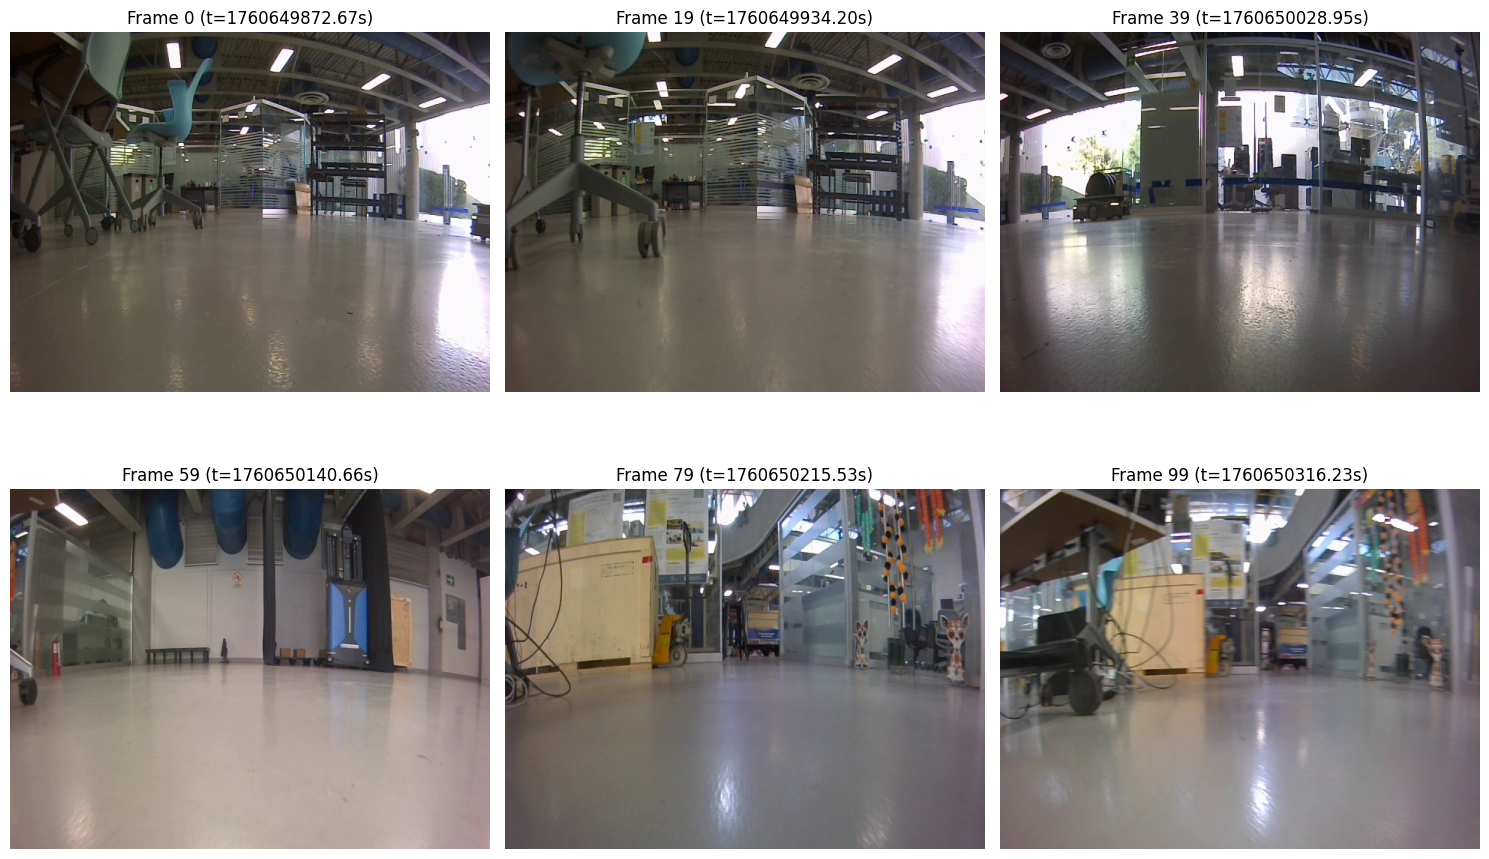


✅ Sample images saved to: sample_images.png


In [18]:
# Extract images from camera topic
print("=" * 60)
print("EXTRACTING CAMERA IMAGES")
print("=" * 60)

camera_topic = '/csi_cam_0/image_raw/compressed'
images = []
image_timestamps = []

with Reader(bag_path) as reader:
    print(f"\nExtracting images from: {camera_topic}")

    for connection, timestamp, rawdata in tqdm(reader.messages()):
        if connection.topic == camera_topic:
            try:
                # Try to deserialize the message
                msg = typestore.deserialize_ros1(rawdata, connection.msgtype)

                # Decode compressed image
                np_arr = np.frombuffer(msg.Data, np.uint8)
                img = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)

                if img is not None:
                    images.append(img)
                    image_timestamps.append(timestamp * 1e-9)
            except (UnicodeDecodeError, Exception):
                # If deserialization fails, try extracting raw image data
                try:
                    # Look for JPEG start marker
                    data = bytes(rawdata)
                    jpeg_start = data.find(b'\xff\xd8\xff')

                    if jpeg_start != -1:
                        image_data = data[jpeg_start:]
                        np_arr = np.frombuffer(image_data, np.uint8)
                        img = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)

                        if img is not None:
                            images.append(img)
                            image_timestamps.append(timestamp * 1e-9)
                except:
                    continue

print(f"\n✅ Extracted {len(images)} images")

# Display sample images
if len(images) > 0:
    num_samples = min(6, len(images))
    sample_indices = np.linspace(0, len(images)-1, num_samples, dtype=int)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for i, idx in enumerate(sample_indices):
        img_rgb = cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB)
        axes[i].imshow(img_rgb)
        axes[i].set_title(f"Frame {idx} (t={image_timestamps[idx]:.2f}s)")
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig('sample_images.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✅ Sample images saved to: sample_images.png")

### 2. Image Properties Analysis

In [19]:
# Analyze image properties
print("=" * 60)
print("IMAGE PROPERTIES ANALYSIS")
print("=" * 60)

if len(images) > 0:
    # Get dimensions
    heights = [img.shape[0] for img in images]
    widths = [img.shape[1] for img in images]
    channels = [img.shape[2] for img in images]

    print(f"\n📐 Image Dimensions:")
    print(f"   Width: {widths[0]} pixels (consistent: {len(set(widths)) == 1})")
    print(f"   Height: {heights[0]} pixels (consistent: {len(set(heights)) == 1})")
    print(f"   Channels: {channels[0]} (consistent: {len(set(channels)) == 1})")
    print(f"   Aspect Ratio: {widths[0]/heights[0]:.2f}")

    # Calculate average file sizes from already extracted images
    compressed_sizes = []
    with Reader(bag_path) as reader:
        for connection, timestamp, rawdata in reader.messages():
            if connection.topic == camera_topic:
                try:
                    msg = typestore.deserialize_ros1(rawdata, connection.msgtype)
                    compressed_sizes.append(len(msg.Data))
                except:
                    # If deserialization fails, estimate from rawdata size
                    # Compressed image data is typically most of the message
                    compressed_sizes.append(len(rawdata) - 100)  # Rough estimate minus header

    if len(compressed_sizes) > 0:
        print(f"\n💾 Compression Analysis:")
        print(f"   Average compressed size: {np.mean(compressed_sizes)/1024:.2f} KB")
        print(f"   Min compressed size: {np.min(compressed_sizes)/1024:.2f} KB")
        print(f"   Max compressed size: {np.max(compressed_sizes)/1024:.2f} KB")
        print(f"   Std dev: {np.std(compressed_sizes)/1024:.2f} KB")

        # Uncompressed size
        uncompressed_size = widths[0] * heights[0] * channels[0]
        compression_ratio = uncompressed_size / np.mean(compressed_sizes)
        print(f"   Uncompressed size: {uncompressed_size/1024:.2f} KB")
        print(f"   Compression ratio: {compression_ratio:.2f}x")
    else:
        print(f"\n💾 Compression Analysis: Could not extract size data")

IMAGE PROPERTIES ANALYSIS

📐 Image Dimensions:
   Width: 640 pixels (consistent: True)
   Height: 480 pixels (consistent: True)
   Channels: 3 (consistent: True)
   Aspect Ratio: 1.33

💾 Compression Analysis:
   Average compressed size: 34.93 KB
   Min compressed size: 22.24 KB
   Max compressed size: 48.80 KB
   Std dev: 7.10 KB
   Uncompressed size: 900.00 KB
   Compression ratio: 25.77x


### 3. Brightness and Exposure Analysis

BRIGHTNESS AND EXPOSURE ANALYSIS

💡 Brightness Statistics (0-255 scale):
   Mean brightness: 109.86
   Std dev: 13.85
   Min brightness: 84.46
   Max brightness: 136.07

⚠️  Exposure Issues:
   Potentially overexposed frames (>200): 0 (0.0%)
   Potentially underexposed frames (<50): 0 (0.0%)


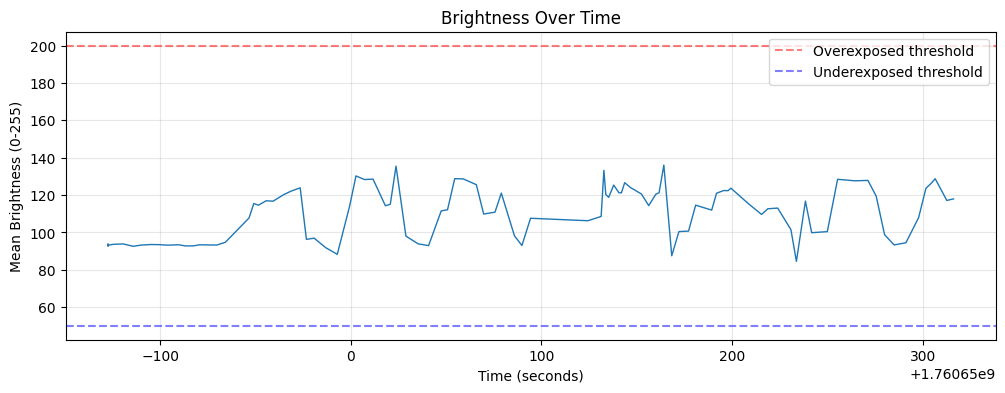


✅ Brightness plot saved to: brightness_analysis.png


In [20]:
# Analyze brightness and exposure
print("=" * 60)
print("BRIGHTNESS AND EXPOSURE ANALYSIS")
print("=" * 60)

if len(images) > 0:
    brightness_values = []

    for img in images:
        # Convert to grayscale and calculate mean brightness
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        brightness = np.mean(gray)
        brightness_values.append(brightness)

    brightness_values = np.array(brightness_values)

    print(f"\n💡 Brightness Statistics (0-255 scale):")
    print(f"   Mean brightness: {np.mean(brightness_values):.2f}")
    print(f"   Std dev: {np.std(brightness_values):.2f}")
    print(f"   Min brightness: {np.min(brightness_values):.2f}")
    print(f"   Max brightness: {np.max(brightness_values):.2f}")

    # Detect over/underexposed frames
    overexposed = np.sum(brightness_values > 200)
    underexposed = np.sum(brightness_values < 50)

    print(f"\n⚠️  Exposure Issues:")
    print(f"   Potentially overexposed frames (>200): {overexposed} ({100*overexposed/len(images):.1f}%)")
    print(f"   Potentially underexposed frames (<50): {underexposed} ({100*underexposed/len(images):.1f}%)")

    # Plot brightness over time
    plt.figure(figsize=(12, 4))
    plt.plot(image_timestamps, brightness_values, linewidth=1)
    plt.axhline(y=200, color='r', linestyle='--', alpha=0.5, label='Overexposed threshold')
    plt.axhline(y=50, color='b', linestyle='--', alpha=0.5, label='Underexposed threshold')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Mean Brightness (0-255)')
    plt.title('Brightness Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('brightness_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✅ Brightness plot saved to: brightness_analysis.png")

### 4. Color Distribution Analysis

COLOR DISTRIBUTION ANALYSIS

🎨 Average Color Channel Values (0-255):
   Blue:  102.65 ± 15.15
   Green: 106.38 ± 13.48
   Red:   111.40 ± 14.60


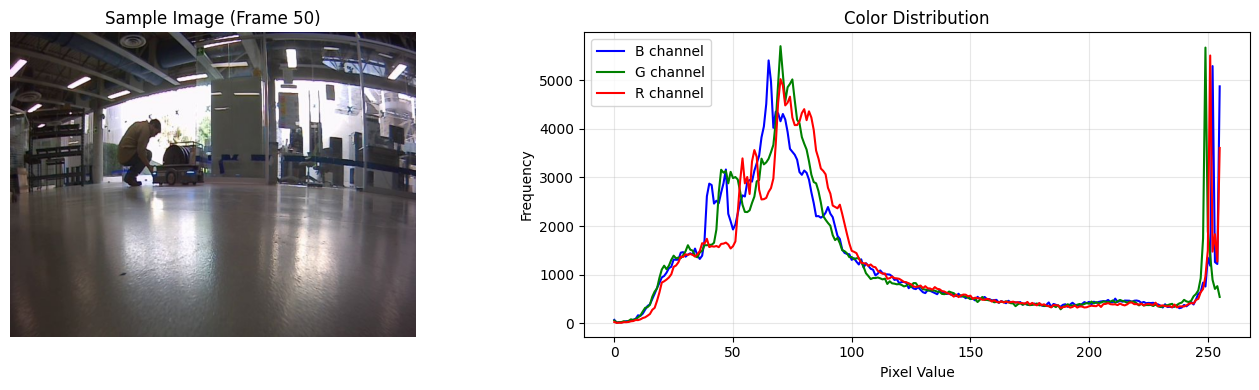


✅ Color distribution plot saved to: color_distribution.png


In [21]:
# Analyze color distribution
print("=" * 60)
print("COLOR DISTRIBUTION ANALYSIS")
print("=" * 60)

if len(images) > 0:
    # Sample a subset of images for detailed analysis
    sample_size = min(20, len(images))
    sample_indices = np.linspace(0, len(images)-1, sample_size, dtype=int)

    # Calculate average color channels
    avg_blue = []
    avg_green = []
    avg_red = []

    for idx in sample_indices:
        img = images[idx]
        avg_blue.append(np.mean(img[:,:,0]))
        avg_green.append(np.mean(img[:,:,1]))
        avg_red.append(np.mean(img[:,:,2]))

    print(f"\n🎨 Average Color Channel Values (0-255):")
    print(f"   Blue:  {np.mean(avg_blue):.2f} ± {np.std(avg_blue):.2f}")
    print(f"   Green: {np.mean(avg_green):.2f} ± {np.std(avg_green):.2f}")
    print(f"   Red:   {np.mean(avg_red):.2f} ± {np.std(avg_red):.2f}")

    # Plot color histograms for a sample image
    mid_idx = len(images) // 2
    sample_img = images[mid_idx]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    # Display sample image
    ax1.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
    ax1.set_title(f'Sample Image (Frame {mid_idx})')
    ax1.axis('off')

    # Plot histograms
    colors = ('b', 'g', 'r')
    for i, color in enumerate(colors):
        hist = cv2.calcHist([sample_img], [i], None, [256], [0, 256])
        ax2.plot(hist, color=color, label=f'{color.upper()} channel')

    ax2.set_xlabel('Pixel Value')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Color Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('color_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✅ Color distribution plot saved to: color_distribution.png")

### 5. Motion and Frame Difference Analysis

MOTION AND FRAME DIFFERENCE ANALYSIS

Calculating frame differences...


100%|██████████| 99/99 [00:00<00:00, 1539.82it/s]


🎬 Motion Statistics:
   Mean frame difference: 28.22
   Std dev: 19.46
   Min difference: 1.32
   Max difference: 63.78

🏃 High Motion Detection:
   Motion threshold: 67.13
   High motion frames: 0 (0.0%)


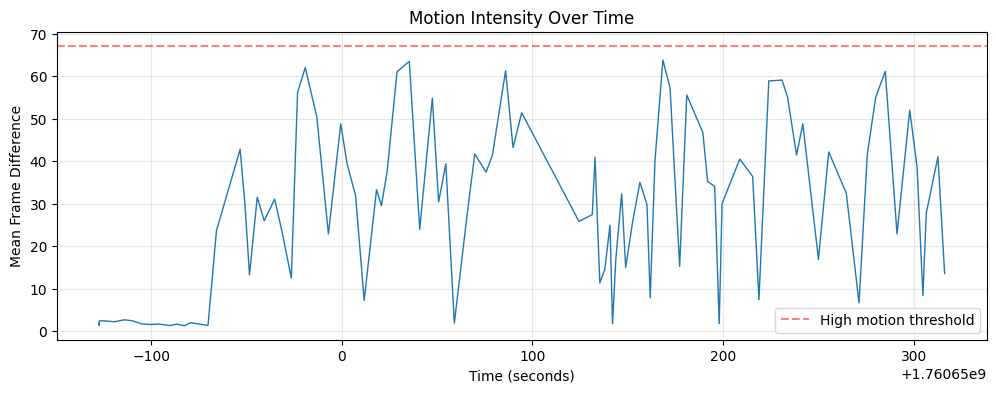


✅ Motion analysis plot saved to: motion_analysis.png


In [22]:
# Analyze motion between frames
print("=" * 60)
print("MOTION AND FRAME DIFFERENCE ANALYSIS")
print("=" * 60)

if len(images) > 1:
    frame_differences = []

    print("\nCalculating frame differences...")
    for i in tqdm(range(len(images)-1)):
        # Convert to grayscale
        gray1 = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(images[i+1], cv2.COLOR_BGR2GRAY)

        # Calculate absolute difference
        diff = cv2.absdiff(gray1, gray2)
        mean_diff = np.mean(diff)
        frame_differences.append(mean_diff)

    frame_differences = np.array(frame_differences)

    print(f"\n🎬 Motion Statistics:")
    print(f"   Mean frame difference: {np.mean(frame_differences):.2f}")
    print(f"   Std dev: {np.std(frame_differences):.2f}")
    print(f"   Min difference: {np.min(frame_differences):.2f}")
    print(f"   Max difference: {np.max(frame_differences):.2f}")

    # Detect high motion frames
    motion_threshold = np.mean(frame_differences) + 2 * np.std(frame_differences)
    high_motion_frames = np.where(frame_differences > motion_threshold)[0]

    print(f"\n🏃 High Motion Detection:")
    print(f"   Motion threshold: {motion_threshold:.2f}")
    print(f"   High motion frames: {len(high_motion_frames)} ({100*len(high_motion_frames)/(len(images)-1):.1f}%)")

    # Plot frame differences over time
    plt.figure(figsize=(12, 4))
    plt.plot(image_timestamps[1:], frame_differences, linewidth=1)
    plt.axhline(y=motion_threshold, color='r', linestyle='--', alpha=0.5, label='High motion threshold')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Mean Frame Difference')
    plt.title('Motion Intensity Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('motion_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✅ Motion analysis plot saved to: motion_analysis.png")

### 6. Image Quality Metrics

IMAGE QUALITY METRICS

Calculating quality metrics...


100%|██████████| 20/20 [00:00<00:00, 367.17it/s]


📊 Quality Metrics:
   Sharpness (Laplacian variance):
      Mean: 396.23
      Std dev: 255.11
      Range: [63.10, 755.44]

   Contrast (RMS):
      Mean: 47.68
      Std dev: 9.11
      Range: [32.39, 65.36]


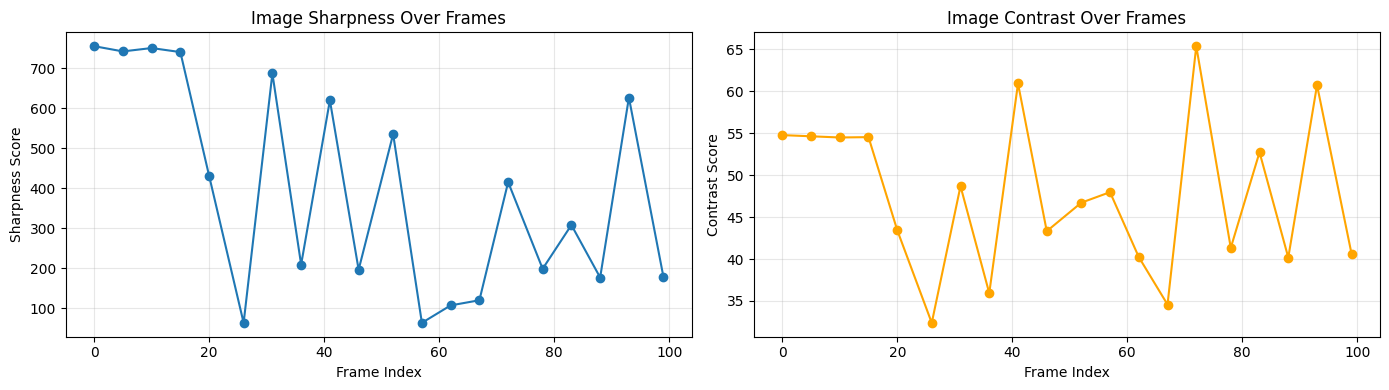


✅ Quality metrics plot saved to: quality_metrics.png


In [23]:
# Calculate image quality metrics
print("=" * 60)
print("IMAGE QUALITY METRICS")
print("=" * 60)

if len(images) > 0:
    # Sample images for quality analysis
    sample_size = min(20, len(images))
    sample_indices = np.linspace(0, len(images)-1, sample_size, dtype=int)

    sharpness_scores = []
    contrast_scores = []

    print("\nCalculating quality metrics...")
    for idx in tqdm(sample_indices):
        img = images[idx]
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Sharpness (using Laplacian variance)
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        sharpness = laplacian.var()
        sharpness_scores.append(sharpness)

        # Contrast (RMS contrast)
        contrast = gray.std()
        contrast_scores.append(contrast)

    print(f"\n📊 Quality Metrics:")
    print(f"   Sharpness (Laplacian variance):")
    print(f"      Mean: {np.mean(sharpness_scores):.2f}")
    print(f"      Std dev: {np.std(sharpness_scores):.2f}")
    print(f"      Range: [{np.min(sharpness_scores):.2f}, {np.max(sharpness_scores):.2f}]")

    print(f"\n   Contrast (RMS):")
    print(f"      Mean: {np.mean(contrast_scores):.2f}")
    print(f"      Std dev: {np.std(contrast_scores):.2f}")
    print(f"      Range: [{np.min(contrast_scores):.2f}, {np.max(contrast_scores):.2f}]")

    # Plot quality metrics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    ax1.plot(sample_indices, sharpness_scores, 'o-')
    ax1.set_xlabel('Frame Index')
    ax1.set_ylabel('Sharpness Score')
    ax1.set_title('Image Sharpness Over Frames')
    ax1.grid(True, alpha=0.3)

    ax2.plot(sample_indices, contrast_scores, 'o-', color='orange')
    ax2.set_xlabel('Frame Index')
    ax2.set_ylabel('Contrast Score')
    ax2.set_title('Image Contrast Over Frames')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('quality_metrics.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✅ Quality metrics plot saved to: quality_metrics.png")

### 7. Camera Image EDA Summary Report

In [24]:
# Generate comprehensive image EDA summary
print("=" * 60)
print("CAMERA IMAGE EDA - SUMMARY REPORT")
print("=" * 60)

if len(images) > 0:
    image_summary = f"""
📸 CAMERA IMAGE EDA SUMMARY
{'='*60}

BASIC INFORMATION:
  • Topic: {camera_topic}
  • Total Frames: {len(images)}
  • Duration: {image_timestamps[-1] - image_timestamps[0]:.2f} seconds
  • Average FPS: {len(images)/(image_timestamps[-1] - image_timestamps[0]):.2f}

IMAGE PROPERTIES:
  • Resolution: {widths[0]}x{heights[0]} pixels
  • Aspect Ratio: {widths[0]/heights[0]:.2f}
  • Color Channels: {channels[0]}
  • Average Compressed Size: {np.mean(compressed_sizes)/1024:.2f} KB
  • Compression Ratio: {compression_ratio:.2f}x

BRIGHTNESS ANALYSIS:
  • Mean Brightness: {np.mean(brightness_values):.2f} / 255
  • Brightness Std Dev: {np.std(brightness_values):.2f}
  • Overexposed Frames: {overexposed} ({100*overexposed/len(images):.1f}%)
  • Underexposed Frames: {underexposed} ({100*underexposed/len(images):.1f}%)

COLOR DISTRIBUTION:
  • Average Blue: {np.mean(avg_blue):.2f}
  • Average Green: {np.mean(avg_green):.2f}
  • Average Red: {np.mean(avg_red):.2f}

MOTION ANALYSIS:
  • Mean Frame Difference: {np.mean(frame_differences):.2f}
  • High Motion Frames: {len(high_motion_frames)} ({100*len(high_motion_frames)/(len(images)-1):.1f}%)

QUALITY METRICS:
  • Average Sharpness: {np.mean(sharpness_scores):.2f}
  • Average Contrast: {np.mean(contrast_scores):.2f}

OUTPUT FILES:
  • sample_images.png
  • brightness_analysis.png
  • color_distribution.png
  • motion_analysis.png
  • quality_metrics.png
"""

    print(image_summary)

    # Save summary report
    with open('image_eda_summary.txt', 'w') as f:
        f.write(image_summary)

    print("\n✅ Image EDA summary saved to: image_eda_summary.txt")
else:
    print("\n⚠️  No images found for analysis")

CAMERA IMAGE EDA - SUMMARY REPORT

📸 CAMERA IMAGE EDA SUMMARY

BASIC INFORMATION:
  • Topic: /csi_cam_0/image_raw/compressed
  • Total Frames: 100
  • Duration: 443.56 seconds
  • Average FPS: 0.23

IMAGE PROPERTIES:
  • Resolution: 640x480 pixels
  • Aspect Ratio: 1.33
  • Color Channels: 3
  • Average Compressed Size: 34.93 KB
  • Compression Ratio: 25.77x

BRIGHTNESS ANALYSIS:
  • Mean Brightness: 109.86 / 255
  • Brightness Std Dev: 13.85
  • Overexposed Frames: 0 (0.0%)
  • Underexposed Frames: 0 (0.0%)

COLOR DISTRIBUTION:
  • Average Blue: 102.65
  • Average Green: 106.38
  • Average Red: 111.40

MOTION ANALYSIS:
  • Mean Frame Difference: 28.22
  • High Motion Frames: 0 (0.0%)

QUALITY METRICS:
  • Average Sharpness: 396.23
  • Average Contrast: 47.68

OUTPUT FILES:
  • sample_images.png
  • brightness_analysis.png
  • color_distribution.png
  • motion_analysis.png
  • quality_metrics.png


✅ Image EDA summary saved to: image_eda_summary.txt
